<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/main/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Featurized Models for Sentiment Analysis

For this assignment, we provide an implementation of a simple binary classifier that will predict the sentiment of a movie review based on a group of original features -- provided by you! 

Before diving into any code, please read through the associated [PDF](https://github.com/dbamman/nlp23/blob/main/HW1/HW1.pdf) for an overview of the assignment and specific instructions on how to submit.

In [ ]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Intro: Gather Data + Create Classifier

#### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [ ]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/test.txt

--2023-01-30 02:14:33--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.05s   

2023-01-30 02:14:33 (23.8 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2023-01-30 02:14:33--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [35]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

#### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed movie reviews in order to make predictions on our test set.

In [ ]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

#### Simple Classifier example

Let's create an initial classifier based on a really simple feature using a dictionary: 

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and 
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [ ]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data. 

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [ ]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [ ]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

To show your work: describe your new features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words|Bag of words takes into account of whether any word has appeared in a document. <br/> This means that the review is more likely to be positive. It is rather comprehensive and considers all words in a document. <br/> For instance, if we see more positive words occuring and are missing most negative words, |0.766|
|Feature 1 : Bigram Count|The bigram feature is able to capture not only words themselves but also neighboring words. <br/> This allows more information about the context to be represented in the feature vectors, thus potentially improving performance.|0.705|
|Feature 2 : Number of self-selected words|I hand-picked some words that may indicate positive and negative emotions. <br/> This is supposed to perform better than Bag of Words because <br/> I encoded my domain knowledge (which words express positive emotions and negative emotions) into the features. <br/> Also, by reducing the number of features, overfitting could be mitigated.|0.593|
|Feature 3 : AFINN-111 lexicon|I encoded the count of words of different emotion scores as a feature. <br/> AFINN is a widely used sentiment analysis dataset and is relatively large. <br/> It is more "specialized" towards sentiment analysis.|0.719|

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment. Consider the type of data you are working with: what do you look for when writing/reading a movie review?

### Implement Bag-of-Words

In [90]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    # BEGIN SOLUTION
    feats = {}

    for token in nltk.word_tokenize(text):
        feats[token] = 1
    
    return feats
    # END SOLUTION

In [92]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=20)
bow_classifier.evaluate()

Method: bag_of_words, Features: 1074, Train accuracy: 1.000, Dev accuracy: 0.766


### Implement Original Features

In [93]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    tokens = nltk.bigrams(nltk.word_tokenize(text))
    for bigram in tokens:
        if bigram in feats:
            feats[bigram] += 1
        else:
            feats[bigram] = 1
               
    return feats

In [94]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=20)
classifier1.evaluate()

Method: feature1, Features: 1001, Train accuracy: 0.994, Dev accuracy: 0.705


In [102]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {"positive" : 0, "negative" : 0}
    pos_words = ["amazing", "interesting", "intriguing", "fascinating", "love"]
    neg_words = ["boring", "bland", "waste", "poor", "hate", "dislike"]
    for token in nltk.word_tokenize(text):
        if token in pos_words:
            feats["positive"] += 1
        if token in neg_words:
            feats["negative"] += 1
            
    return feats

In [103]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=20)
classifier2.evaluate()

Method: feature2, Features: 2, Train accuracy: 0.618, Dev accuracy: 0.593


In [54]:
!wget https://raw.githubusercontent.com/CircleCly/info159-sp23/main/HW1/AFINN-111.txt

--2023-01-30 05:01:45--  https://raw.githubusercontent.com/CircleCly/info159-sp23/main/HW1/AFINN-111.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28093 (27K) [text/plain]
Saving to: ‘AFINN-111.txt’

AFINN-111.txt       100%[===================>]  27.43K  --.-KB/s    in 0.001s  

2023-01-30 05:01:45 (19.7 MB/s) - ‘AFINN-111.txt’ saved [28093/28093]



In [104]:
afinn = pd.read_csv("AFINN-111.txt", delimiter = '\t', header = None).to_numpy()
afinn_dict = {k : v for k, v in afinn}

In [105]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    for word in nltk.word_tokenize(text):
        score = (afinn_dict.get(word) or 0)
        feats[score] = (feats.get(score) or 0) + 1
            
    return feats

In [106]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=20)
classifier3.evaluate()

Method: feature3, Features: 10, Train accuracy: 0.730, Dev accuracy: 0.719


## Deliverable 2

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`.

Download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 students with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding). 

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [107]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.
    
    all_feats={}
    for feature in [bag_of_words, feature1, feature2, feature3]:
        all_feats.update(feature(text))
    return all_feats

In [108]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=20)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 2086, Train accuracy: 1.000, Dev accuracy: 0.767


## Further Exploration: Interrogating classifiers

Note: No deliverables are in this section; it's optional. Treat this portion as a useful tool for further understanding the features you worked on and how they affter the classifier.

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


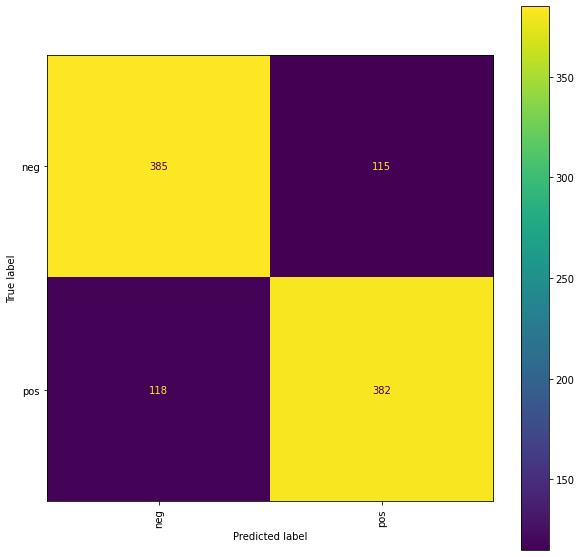

In [109]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [110]:
big_classifier.printWeights(n=25)

pos	0.687	very
pos	0.660	('.', 'It')
pos	0.638	in
pos	0.638	violence
pos	0.637	!
pos	0.628	3
pos	0.603	us
pos	0.598	('.', 'This')
pos	0.568	(',', 'so')
pos	0.566	top
pos	0.543	back
pos	0.540	(',', 'then')
pos	0.527	My
pos	0.516	friends
pos	0.508	incredible
pos	0.482	thought
pos	0.479	dead
pos	0.476	anyone
pos	0.465	amazing
pos	0.462	late
pos	0.455	('when', 'I')
pos	0.449	('I', 'was')
pos	0.448	atmosphere
pos	0.445	great
pos	0.442	down

neg	-0.846	?
neg	-0.739	actors
neg	-0.724	worst
neg	-0.667	idea
neg	-0.652	watching
neg	-0.650	acting
neg	-0.611	negative
neg	-0.592	would
neg	-0.588	far
neg	-0.583	('.', '*')
neg	-0.576	('the', 'worst')
neg	-0.550	('to', 'watch')
neg	-0.546	('.', 'There')
neg	-0.543	nothing
neg	-0.540	me
neg	-0.524	could
neg	-0.520	('film', 'was')
neg	-0.517	there
neg	-0.509	(',', 'I')
neg	-0.495	('they', 'were')
neg	-0.492	boring
neg	-0.491	('film', "'s")
neg	-0.489	put
neg	-0.489	name
neg	-0.488	funny



3. Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them?

In [111]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [112]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1004,0.999955,neg,pos,"Certainly NOMAD has some of the best horse riding scenes, swordplay, and scrumptious landscape cinematography you'll likely see, but this isn't what makes a film good. It helps but the story has to shine through on top of these things. And that's where Nomad wanders.The story is stilted, giving it a sense that it was thrown together simply to make a ""cool"" movie that ""looks"" great. Not to ment..."
1,1436,0.999732,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
2,1110,0.999721,neg,pos,"Before Stan Laurel became the smaller half of the all-time greatest comedy team, he laboured under contract to Broncho Billy Anderson in a series of cheapies, many of which were parodies of major Hollywood features. Following a dispute with Anderson, Laurel continued the informal series of parodies at Joe Rock's smaller (and more indigent) production company.Most of Laurel's parody films were ..."
3,1959,0.999402,pos,neg,"This is one of the best episode from the second season of MOH, I think Mick Garris has a problem with women... He kill'em all, they are often the victims (Screwfly solution, Pro-life, Valerie on the stairs, I don't remember the Argento's episode in season 1, etc., obviously Imprint). I think he enjoys to watch women been burn, torture, mutilated and I don't know. Never least ""Right to die"" is ..."
4,1075,0.999199,neg,pos,"A still famous but decadent actor (Morgan Freeman) has not filmed for four years. When he is invited to participate in a new project, he asks the clumsy cousin of the director to drop him in a poor Latin neighborhood in Carlson to research the work of the manager of a small supermarket. He sees the gorgeous Spanish cashier Scarlet (Paz Vega) and he becomes attracted with her ability. His drive..."
5,1896,0.999139,neg,pos,"STAR RATING: ***** The Works **** Just Misses the Mark *** That Little Bit In Between ** Lagging Behind * The Pits In this debut effort for Nick Park's beloved man and dog, they are forced to fly to the moon when good old Wallace runs out of cheese.As well as being the shortest feature at just 22 minutes, this W/G adventure is also the earliest and it kinda shows. The plasticine animation is a..."
6,1206,0.999111,neg,pos,"Plot Synopsis: Hong Kong, 1966. Paul Wagner, the man who built the Victoria Tunnel, is murdered along with his wife by his associates. His twin sons, Chad & Alex, are split apart. 25 years later, Chad, a karate instructor in Los Angeles, & Alex, a smuggler living in Hong Kong, join forces to avenge their parents' murder & rightfully claim the tunnel.This is the second time that Jean-Claude Van..."
7,1659,0.998835,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
8,1320,0.998798,neg,pos,This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations f...
9,1608,0.998704,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling"